In [1]:
import tensorflow as tf
import keras
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()
from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout, Flatten
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from datetime import datetime
#import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt

Using TensorFlow backend.


In [2]:
class GRU_RNN:

    def __init__(self, look_back, batch_size, ip_size, dropout_probability = 0.1, init ='he_uniform', loss='mse', optimizer='adam'):
        self.rnn = Sequential()
        self.batch_size = batch_size
        self.look_back = look_back
        self.rnn.add(GRU(128, input_shape=(None, ip_size), init=init, return_sequences=True))
        self.rnn.add(Dropout(dropout_probability))
#         self.rnn.add(Flatten())
        self.rnn.add(Dense(1, init=init))
        self.rnn.compile(loss=loss, optimizer=optimizer)

    def train(self, X, Y, nb_epoch=150):
        self.rnn.fit(X, Y, nb_epoch=nb_epoch, batch_size=self.batch_size, verbose=2)

    def evaluate(self, X, Y):
        score = self.rnn.evaluate(X, Y, batch_size = self.batch_size, verbose=0)
        print(score)
        return score

    def predict(self, X):
        return self.rnn.predict(X)

In [3]:
def parser(x):
    return datetime.strptime(x, '%d-%b-%Y')

def get_data(path, date):
    data = pd.read_csv(path , header=0, parse_dates=[date], index_col=date, squeeze=True, date_parser=parser)
    return data

In [4]:
def evaluate_models(look_back, batch_size, trainX, trainY, testX, testY, ret=False):
    print('Training & evaluating GRU-RNN for batch size = ' + str(batch_size) + '...')
    (_, _, j) = trainX.shape
    if j > look_back:
        gru_model = GRU_RNN(look_back, batch_size, ip_size=j)
    else:
        gru_model = GRU_RNN(look_back, batch_size, ip_size=look_back)
    gru_model.train(trainX, trainY)
    gru_test_mse = gru_model.evaluate(testX, testY)
    print("With batch size = " + str(batch_size) + ", Score: " + str(gru_test_mse))
    print('Completed model evaluation for batch size = ' + str(batch_size) + '...')
    if ret:
        yhat = gru_model.predict(testX)
        return gru_test_mse, yhat
    del gru_model
    return gru_test_mse

In [5]:
def print_results(gru_mse_vals):
    print('Completed model evaluation for all lookback values...')
    gru_mse_min = min(gru_mse_vals)
    gru_mse_argmin = np.argmin(gru_mse_vals) + 1
    print('Best mse with a GRU recurrent neural network was ' + str(gru_mse_min) + ' with a batch size of ' + str(gru_mse_argmin))
    return gru_mse_argmin

In [6]:
np.random.seed(10)
look_back = 5
x = get_data('../ml-project-data/NIFTY-50/2014.csv', 0)
y = x.loc[: , "High":"Low"].mean(axis=1)
data_y = y       
x_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    x_lag['t-'+str(i)] = y.shift(i)
x = x_lag

x = x.iloc[look_back:]
y = y.iloc[look_back:]

act_data = get_data('../ml-project-data/NIFTY-50/2015.csv', 0)
act = act_data.loc[: , "High":"Low"].mean(axis=1)
act = act[:int(len(act)/4)]
idx = act_data.index
idx = idx[:int(len(idx)/4)]
act_y = act
act = pd.concat([y[-5:], act])

act_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    act_lag['t-'+str(i)] = act.shift(i)

act = act_lag[look_back:]

scaler = MinMaxScaler()
x = scaler.fit_transform(x.values)
y = scaler.fit_transform(y.values.reshape(-1, 1))
act = scaler.fit_transform(act.values)
act_y = scaler.fit_transform(act_y.values.reshape(-1, 1))

i, j = x.shape
x = x.reshape(1, i , j)
y = y.reshape(1, len(y), 1)
i,j = act.shape
act = act.reshape(1, i , j)
act_y = act_y.reshape(1, len(act_y), 1)

In [7]:
##Ran this on kaggle to get an optimum value of 22
# mse_vals = []
# for batch_size in range(1, 51):
#     np.random.seed(10)
#     mse_vals.append(evaluate_models(look_back, batch_size, x, y, act, act_y))
# min_bs = print_results(mse_vals)

In [8]:
min_bs = 22
np.random.seed(10)
mse_val, y_hat = evaluate_models(look_back, min_bs, x, y, act, act_y, True)

Training & evaluating GRU-RNN for batch size = 22...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, input_shape=(None, 5), return_sequences=True, kernel_initializer="he_uniform")`
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/150
 - 1s - loss: 0.3563
Epoch 2/150
 - 0s - loss: 0.0865
Epoch 3/150
 - 0s - loss: 0.1480
Epoch 4/150
 - 0s - loss: 0.1952
Epoch 5/150
 - 0s - loss: 0.1995
Epoch 6/150
 - 0s - loss: 0.0923
Epoch 7/150
 - 0s - loss: 0.0735
Epoch 8/150
 - 0s - loss: 0.0999
Epoch 9/150
 - 0s - loss: 0.1111
Epoch 10/150
 - 0s - loss: 0.1186
Epoch 11/150
 - 0s - loss: 0.0979
Epoch 12/150
 - 0s - loss: 0.1003
Epoch 13/150
 - 0s - loss: 0.0968
Epoch 14/150
 - 0s - loss: 0.0795
Epoch 15/150
 - 0s - loss: 0.0769
Epoch 16/150
 - 0s - loss: 0.0663
Epoch 17/150
 - 0s - loss: 0.0794
Epoch 18/150
 - 0s - loss: 0.0932
Epoch 19/150
 - 0s - loss: 0.0691
Epoch 20/150
 - 0s - loss: 0.0746
Epoch 21/150
 - 0s - loss: 0.0659
Epoch 22/150
 - 0s - loss: 0.0727
Epoch 23/150
 - 0s - loss: 0.0716
Epoch 24/150
 - 0s - loss: 0.0734
Epoch 25/150
 - 0s - loss: 0.0786
Epoch 26/150
 - 0s - loss: 0.0706
Epoch 27/150
 - 0s - loss: 0.0666
Epoch 28/150
 - 0s - loss: 0.0639
Epoch 29/150
 - 0s - loss: 0.0677
Epoch 30/150
 - 0s - lo

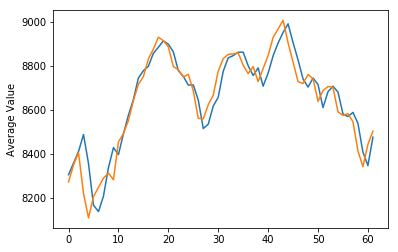

In [9]:
y_hat = y_hat.reshape(len(y_hat[0]))
act = act_y.reshape(len(act_y[0]))

preds = pd.DataFrame(y_hat,columns=['Prediction'],index=idx)
actuals = pd.DataFrame(act,columns=['Actual'],index=idx)

preds = scaler.inverse_transform(preds)
actuals = scaler.inverse_transform(actuals)

plt.plot(preds, label="Prediction")
plt.plot(actuals, label="Actual")
plt.ylabel("Average Value")
plt.show()

In [10]:
rms = sqrt(mean_squared_error(actuals, preds))
print('RMSE: ' + str(rms))

mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
print('MAPE: ' + str(mape))

RMSE: 75.01225424709943
MAPE: 0.6413057052836146


In [16]:
np.random.seed(10)
look_back = 5
tcs_x = get_data('../ml-project-data/TCS/01-01-2014-TO-31-12-2014TCSEQN.csv', 2)['Average Price']
tcs_y = tcs_x
        
tcs_x_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    tcs_x_lag['t-'+str(i)] = tcs_y.shift(i)
tcs_x = tcs_x_lag

tcs_x = tcs_x.iloc[look_back:]
tcs_y = tcs_y.iloc[look_back:]

tcs_act_data = get_data('../ml-project-data/TCS/01-01-2015-TO-31-12-2015TCSEQN.csv', 2)['Average Price']
tcs_act = tcs_act_data[:int(len(tcs_act_data)/4)]
tcs_idx = tcs_act_data.index
tcs_idx = tcs_idx[:int(len(idx)/4)]
tcs_act_y = tcs_act
tcs_act = pd.concat([tcs_y[-5:], tcs_act])

tcs_act_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    tcs_act_lag['t-'+str(i)] = tcs_act.shift(i)

tcs_act = tcs_act_lag[look_back:]

scaler = MinMaxScaler()
tcs_x = scaler.fit_transform(tcs_x.values)
tcs_y = scaler.fit_transform(tcs_y.values.reshape(-1, 1))
tcs_act = scaler.fit_transform(tcs_act.values)
tcs_act_y = scaler.fit_transform(tcs_act_y.values.reshape(-1, 1))

i, j = tcs_x.shape
tcs_x = tcs_x.reshape(1, i , j)
tcs_y = tcs_y.reshape(1, len(tcs_y), 1)
i,j = tcs_act.shape
tcs_act = tcs_act.reshape(1, i , j)
tcs_act_y = tcs_act_y.reshape(1, len(tcs_act_y), 1)

In [17]:
# mse_vals = []
# for batch_size in range(1, 51):
#     np.random.seed(10)
#     mse_vals.append(evaluate_models(look_back, batch_size, tcs_x, tcs_y, tcs_act, tcs_act_y))
# min_bs = print_results(mse_vals)

In [18]:
np.random.seed(10)
min_bs = 35
tcs_mse_val, tcs_y_hat = evaluate_models(look_back, min_bs, tcs_x, tcs_y, tcs_act, tcs_act_y, True)

Training & evaluating GRU-RNN for batch size = 35...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, input_shape=(None, 5), return_sequences=True, kernel_initializer="he_uniform")`
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/150
 - 1s - loss: 0.3233
Epoch 2/150
 - 0s - loss: 0.0821
Epoch 3/150
 - 0s - loss: 0.1293
Epoch 4/150
 - 0s - loss: 0.1727
Epoch 5/150
 - 0s - loss: 0.1794
Epoch 6/150
 - 0s - loss: 0.0873
Epoch 7/150
 - 0s - loss: 0.0674
Epoch 8/150
 - 0s - loss: 0.0862
Epoch 9/150
 - 0s - loss: 0.0923
Epoch 10/150
 - 0s - loss: 0.1018
Epoch 11/150
 - 0s - loss: 0.0939
Epoch 12/150
 - 0s - loss: 0.0926
Epoch 13/150
 - 0s - loss: 0.0874
Epoch 14/150
 - 0s - loss: 0.0722
Epoch 15/150
 - 0s - loss: 0.0612
Epoch 16/150
 - 0s - loss: 0.0559
Epoch 17/150
 - 0s - loss: 0.0748
Epoch 18/150
 - 0s - loss: 0.0899
Epoch 19/150
 - 0s - loss: 0.0656
Epoch 20/150
 - 0s - loss: 0.0629
Epoch 21/150
 - 0s - loss: 0.0617
Epoch 22/150
 - 0s - loss: 0.0609
Epoch 23/150
 - 0s - loss: 0.0640
Epoch 24/150
 - 0s - loss: 0.0613
Epoch 25/150
 - 0s - loss: 0.0718
Epoch 26/150
 - 0s - loss: 0.0647
Epoch 27/150
 - 0s - loss: 0.0587
Epoch 28/150
 - 0s - loss: 0.0568
Epoch 29/150
 - 0s - loss: 0.0588
Epoch 30/150
 - 0s - lo

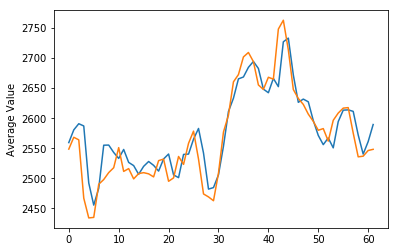

In [19]:
tcs_y_hat = tcs_y_hat.reshape(len(tcs_y_hat[0]))
tcs_act = tcs_act_y.reshape(len(tcs_act_y[0]))

tcs_preds = pd.DataFrame(tcs_y_hat,columns=['Prediction'],index=idx)
tcs_actuals = pd.DataFrame(tcs_act,columns=['Actual'],index=idx)

tcs_preds = scaler.inverse_transform(tcs_preds)
tcs_actuals = scaler.inverse_transform(tcs_actuals)

plt.plot(tcs_preds, label="Prediction")
plt.plot(tcs_actuals, label="Actual")
plt.ylabel("Average Value")
plt.show()

In [20]:
rms = sqrt(mean_squared_error(tcs_actuals, tcs_preds))
print('RMSE: ' + str(rms))

mape = np.mean(np.abs((tcs_actuals - tcs_preds) / tcs_actuals)) * 100
print('MAPE: ' + str(mape))

RMSE: 32.37100481503993
MAPE: 0.92036676218213


In [26]:
np.random.seed(10)
look_back = 5
tcs_x = get_data('../ml-project-data/TCS/01-01-2014-TO-31-12-2014TCSEQN.csv', 2)['Average Price']
tcs_y = tcs_x
        
tcs_x_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    tcs_x_lag['t-'+str(i)] = tcs_y.shift(i)
tcs_x = tcs_x_lag

tcs_x = tcs_x.iloc[look_back:]
tcs_y = tcs_y.iloc[look_back:]

tcs_act_data = get_data('../ml-project-data/TCS/01-01-2015-TO-31-12-2015TCSEQN.csv', 2)['Average Price']
tcs_act = tcs_act_data[:int(len(tcs_act_data)/4)]
tcs_idx = tcs_act_data.index
tcs_idx = tcs_idx[:int(len(idx)/4)]
tcs_act_y = tcs_act
tcs_act = pd.concat([tcs_y[-5:], tcs_act])

tcs_act_lag = pd.DataFrame()
for i in range(look_back,0,-1):
    tcs_act_lag['t-'+str(i)] = tcs_act.shift(i)

tcs_act = tcs_act_lag[look_back:]

tcs_x['nifty'] = data_y
tcs_act['nifty'] = preds

scaler = MinMaxScaler()
tcs_x = scaler.fit_transform(tcs_x.values)
tcs_y = scaler.fit_transform(tcs_y.values.reshape(-1, 1))
tcs_act = scaler.fit_transform(tcs_act.values)
tcs_act_y = scaler.fit_transform(tcs_act_y.values.reshape(-1, 1))

i, j = tcs_x.shape
tcs_x = tcs_x.reshape(1, i , j)
tcs_y = tcs_y.reshape(1, len(tcs_y), 1)
i,j = tcs_act.shape
tcs_act = tcs_act.reshape(1, i , j)
tcs_act_y = tcs_act_y.reshape(1, len(tcs_act_y), 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
# mse_vals = []
# for batch_size in range(1, 51):
#     np.random.seed(10)
#     mse_vals.append(evaluate_models(look_back, batch_size, tcs_x, tcs_y, tcs_act, tcs_act_y))
# min_bs = print_results(mse_vals)

In [28]:
np.random.seed(10)
min_bs = 32
tcs_mse_val, tcs_y_hat = evaluate_models(look_back, min_bs, tcs_x, tcs_y, tcs_act, tcs_act_y, True)

Training & evaluating GRU-RNN for batch size = 32...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, input_shape=(None, 6), return_sequences=True, kernel_initializer="he_uniform")`
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="he_uniform")`
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Epoch 1/150
 - 1s - loss: 0.4123
Epoch 2/150
 - 0s - loss: 0.1763
Epoch 3/150
 - 0s - loss: 0.1075
Epoch 4/150
 - 0s - loss: 0.1697
Epoch 5/150
 - 0s - loss: 0.2562
Epoch 6/150
 - 0s - loss: 0.1689
Epoch 7/150
 - 0s - loss: 0.1180
Epoch 8/150
 - 0s - loss: 0.0835
Epoch 9/150
 - 0s - loss: 0.0715
Epoch 10/150
 - 0s - loss: 0.0907
Epoch 11/150
 - 0s - loss: 0.1069
Epoch 12/150
 - 0s - loss: 0.1235
Epoch 13/150
 - 0s - loss: 0.1209
Epoch 14/150
 - 0s - loss: 0.0968
Epoch 15/150
 - 0s - loss: 0.0643
Epoch 16/150
 - 0s - loss: 0.0706
Epoch 17/150
 - 0s - loss: 0.0708
Epoch 18/150
 - 0s - loss: 0.0739
Epoch 19/150
 - 0s - loss: 0.0752
Epoch 20/150
 - 0s - loss: 0.0823
Epoch 21/150
 - 0s - loss: 0.0798
Epoch 22/150
 - 0s - loss: 0.0871
Epoch 23/150
 - 0s - loss: 0.0713
Epoch 24/150
 - 0s - loss: 0.0583
Epoch 25/150
 - 0s - loss: 0.0651
Epoch 26/150
 - 0s - loss: 0.0619
Epoch 27/150
 - 0s - loss: 0.0695
Epoch 28/150
 - 0s - loss: 0.0780
Epoch 29/150
 - 0s - loss: 0.0823
Epoch 30/150
 - 0s - lo

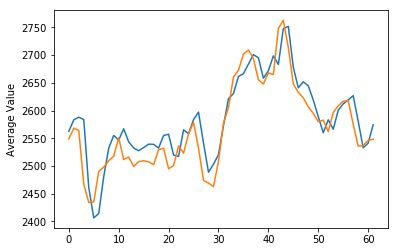

In [29]:
tcs_y_hat = tcs_y_hat.reshape(len(tcs_y_hat[0]))
tcs_act = tcs_act_y.reshape(len(tcs_act_y[0]))

tcs_preds = pd.DataFrame(tcs_y_hat,columns=['Prediction'],index=idx)
tcs_actuals = pd.DataFrame(tcs_act,columns=['Actual'],index=idx)

tcs_preds = scaler.inverse_transform(tcs_preds)
tcs_actuals = scaler.inverse_transform(tcs_actuals)

plt.plot(tcs_preds, label="Prediction")
plt.plot(tcs_actuals, label="Actual")
plt.ylabel("Average Value")
plt.show()

In [30]:
rms = sqrt(mean_squared_error(tcs_actuals, tcs_preds))
print('RMSE: ' + str(rms))

mape = np.mean(np.abs((tcs_actuals - tcs_preds) / tcs_actuals)) * 100
print('MAPE: ' + str(mape))

RMSE: 34.49732414355014
MAPE: 1.0642168052809482
